#Image Deblurring using Generative Adversarial Networks

In [2]:
import numpy as np
import pandas as pd
import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import platform

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jishnuparayilshibu/a-curated-list-of-image-deblurring-datasets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'a-curated-list-of-image-deblurring-datasets' dataset.
Path to dataset files: /kaggle/input/a-curated-list-of-image-deblurring-datasets


In [5]:
import os
gopro_path = os.path.join(path, 'DBlur', 'Gopro')
print(gopro_path)

/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/Gopro


In [7]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        def down(in_c, out_c, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
                nn.InstanceNorm2d(out_c),
                nn.ReLU()
            )

        self.d1 = down(3, 64, norm=False)
        self.d2 = down(64, 128)
        self.d3 = down(128, 256)
        self.d4 = down(256, 512)

        self.u1 = up(512, 256)
        self.u2 = up(512, 128)
        self.u3 = up(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.d1(x)   # 128
        d2 = self.d2(d1)  # 64
        d3 = self.d3(d2)  # 32
        d4 = self.d4(d3)  # 16

        u1 = self.u1(d4)
        u1 = F.interpolate(u1, size=d3.shape[2:], mode="bilinear", align_corners=False)
        u1 = torch.cat([u1, d3], dim=1)
        u2 = self.u2(u1)
        u2 = F.interpolate(u2, size=d2.shape[2:], mode="bilinear", align_corners=False)
        u2 = torch.cat([u2, d2], dim=1)

        u3 = self.u3(u2)
        u3 = F.interpolate(u3, size=d1.shape[2:], mode="bilinear", align_corners=False)
        u3 = torch.cat([u3, d1], dim=1)
        out = self.final(u3)
        out = F.interpolate(out, size=x.shape[2:], mode="bilinear", align_corners=False)
        return out

In [8]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels = 6):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim = 1)
        validity = self.model(combined)
        return validity

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 6):
        super(Discriminator, self).__init__()
        self.d1 = PatchDiscriminator(in_channels)
        self.d2 = PatchDiscriminator(in_channels)

    def forward(self, x, y):
        out1 = self.d1(x, y)
        blur_ds = F.interpolate(
            x, scale_factor=0.5, mode="bilinear", align_corners=False
        )
        sharp_ds = F.interpolate(
            y, scale_factor=0.5, mode="bilinear", align_corners=False
        )
        out2 = self.d2(blur_ds, sharp_ds)
        return out1, out2

In [10]:
transform = transforms.Compose([
    transforms.Resize((640, 360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


In [11]:
# Hyperparameters
in_channels = 6
learning_rate = 1e-4
lr_decay = 1.6e-6
batch_size = 2
num_epochs = 32

In [12]:
class GoProDatasetTrain(Dataset):
    def __init__(self, root = os.path.join(gopro_path, "test"), transform=None):
        self.blur_dir = os.path.join(root, "blur")
        self.sharp_dir = os.path.join(root, "sharp")
        self.transform = transform

        self.images = sorted(os.listdir(self.blur_dir))
        self.images = self.images[:100]
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        blur_path = os.path.join(self.blur_dir, self.images[idx])
        sharp_path = os.path.join(self.sharp_dir, self.images[idx])

        blur = Image.open(blur_path).convert("RGB")
        sharp = Image.open(sharp_path).convert("RGB")

        if self.transform:
            blur = self.transform(blur)
            sharp = self.transform(sharp)
        return blur, sharp


In [13]:
class GoProDatasetTest(Dataset):
    def __init__(self, root = os.path.join(gopro_path, "test"), transform=None):
        self.blur_dir = os.path.join(root, "blur")
        self.sharp_dir = os.path.join(root, "sharp")
        self.transform = transform

        self.images = sorted(os.listdir(self.blur_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        blur_path = os.path.join(self.blur_dir, self.images[idx])
        sharp_path = os.path.join(self.sharp_dir, self.images[idx])

        blur = Image.open(blur_path).convert("RGB")
        sharp = Image.open(sharp_path).convert("RGB")

        if self.transform:
            blur = self.transform(blur)
            sharp = self.transform(sharp)

        return blur, sharp


In [14]:
train_dataset = GoProDatasetTrain(
    root=os.path.join(gopro_path,'train'),
    transform=transform
)

test_dataset = GoProDatasetTest(
    root=os.path.join(gopro_path,'test'),
    transform=transform
)

In [15]:
train_data = DataLoader(
    train_dataset,
    batch_size = batch_size,
    #shuffle=True,
    num_workers=4,
    pin_memory = True
)

test_data = DataLoader(
    test_dataset,
    batch_size = batch_size,
    num_workers=4,
    pin_memory = True
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
def gan_loss(pred, target):
    return torch.mean((pred - target)**2)
l1 = nn.L1Loss()

In [17]:
# Loss function
class VGGPerceptual(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features[:16]
        for p in vgg.parameters():
            p.requires_grad = False
        self.vgg = vgg
    def forward(self, x, y):
        return torch.mean((self.vgg(x) - self.vgg(y))**2)

In [18]:
def old_psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100
    pixel_max = 1.0
    return 20 * torch.log10(pixel_max / torch.sqrt(mse))

In [19]:
# To check the accuracy of the model
def new_psnr(pred, target):
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return torch.tensor(100.0)
    return 10 * torch.log10(1.0 / mse)

In [20]:
G = UNetGenerator().to(device)
D = Discriminator().to(device)
vgg_loss = VGGPerceptual().to(device)
opt_G = optim.Adam(G.parameters(), lr = learning_rate)
opt_D = optim.Adam(D.parameters(), lr = learning_rate)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 109MB/s] 


In [22]:
stagnate_counter = 0
g_steps = 3  # number of generator updates per batch

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    for blur, sharp in train_data:
        blur = blur.to(device)
        sharp = sharp.to(device)

        # ============================
        # Train Discriminator (once)
        # ============================
        opt_D.zero_grad()

        fake_sharp = G(blur)

        real_out1, real_out2 = D(blur, sharp)
        fake_out1, fake_out2 = D(blur, fake_sharp.detach())

        real_label1 = torch.ones_like(real_out1)
        real_label2 = torch.ones_like(real_out2)
        fake_label1 = torch.zeros_like(fake_out1)
        fake_label2 = torch.zeros_like(fake_out2)

        d_loss_real = gan_loss(real_out1, real_label1) + gan_loss(real_out2, real_label2)
        d_loss_fake = gan_loss(fake_out1, fake_label1) + gan_loss(fake_out2, fake_label2)

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        opt_D.step()

        # ============================
        # Train Generator (multiple times)
        # ============================
        for _ in range(g_steps):
            opt_G.zero_grad()

            fake_sharp = G(blur)
            fake_out1, fake_out2 = D(blur, fake_sharp)

            g_gan_criterion = gan_loss(fake_out1, real_label1) + gan_loss(fake_out2, real_label2)
            vgg_criterion = vgg_loss(fake_sharp, sharp)
            l1_criterion = l1(fake_sharp, sharp)

            g_criterion = g_gan_criterion + 0.01 * vgg_criterion + 100 * l1_criterion
            g_criterion.backward()
            opt_G.step()

    if g_criterion.item() < 8.6:
        stagnate_counter += 1
        opt_G = optim.Adam(
            G.parameters(),
            lr=learning_rate - stagnate_counter * lr_decay
        )

    print(f"    D Loss: {d_loss.item():.4f} | G Loss: {g_criterion.item():.4f}")


Epoch [1/32]
    D Loss: 0.5167 | G Loss: 11.2591
Epoch [2/32]
    D Loss: 0.4990 | G Loss: 10.0322
Epoch [3/32]
    D Loss: 0.4755 | G Loss: 9.5230
Epoch [4/32]
    D Loss: 0.5062 | G Loss: 9.1302
Epoch [5/32]
    D Loss: 0.5010 | G Loss: 8.8447
Epoch [6/32]
    D Loss: 0.4977 | G Loss: 8.7324
Epoch [7/32]
    D Loss: 0.4938 | G Loss: 8.5815
Epoch [8/32]
    D Loss: 0.4909 | G Loss: 8.3718
Epoch [9/32]
    D Loss: 0.4858 | G Loss: 8.2598
Epoch [10/32]
    D Loss: 0.4770 | G Loss: 8.1866
Epoch [11/32]
    D Loss: 0.4686 | G Loss: 8.1366
Epoch [12/32]
    D Loss: 0.4725 | G Loss: 8.0769
Epoch [13/32]
    D Loss: 0.4737 | G Loss: 8.0419
Epoch [14/32]
    D Loss: 0.4669 | G Loss: 8.0172
Epoch [15/32]
    D Loss: 0.4355 | G Loss: 7.9849
Epoch [16/32]
    D Loss: 0.4168 | G Loss: 7.9436
Epoch [17/32]
    D Loss: 0.4099 | G Loss: 7.9396
Epoch [18/32]
    D Loss: 0.3938 | G Loss: 7.9294
Epoch [19/32]
    D Loss: 0.3966 | G Loss: 7.8781
Epoch [20/32]
    D Loss: 0.3918 | G Loss: 7.8707
Epoch [

In [23]:
G.eval()   # very important
total_psnr = 0.0
num_batches = 0
total_psnr_blursharp = 0.0
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
with torch.no_grad():
    for blur, sharp in test_data:
        blur = blur.to(device)
        sharp = sharp.to(device)

        fake_sharp = G(blur)

        #Clamp just in case (GANs can overshoot)
        #fake_sharp = torch.clamp(fake_sharp, 0.0, 0.0)
        #fake_sharp = normalize(fake_sharp)
        batch_psnr_blursharp = old_psnr(blur, sharp)
        batch_psnr = new_psnr(fake_sharp, sharp)
        total_psnr += batch_psnr.item()
        total_psnr_blursharp += batch_psnr_blursharp
        num_batches += 1

avg_psnr = total_psnr / num_batches
avg_psnr_blursharp = total_psnr_blursharp / num_batches
print(f"Average PSNR on test set: {avg_psnr:.2f} dB")
print(f"blur-sharp PSNR: {avg_psnr_blursharp:.2f}")


Average PSNR on test set: 25.24 dB
blur-sharp PSNR: 20.66


In [25]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


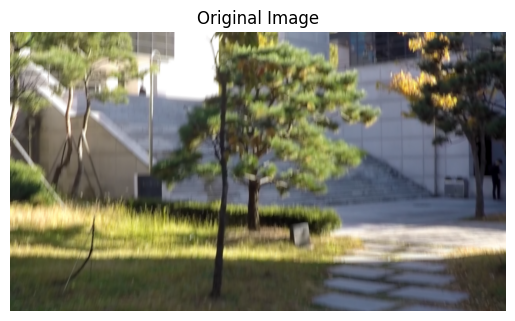

In [26]:
img_path = '/content/drive/MyDrive/Colab Notebooks/blur.png'
blur_img = Image.open(img_path).convert('RGB')  # ensure 3 channels

# Show original image
plt.imshow(blur_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [44]:
transform = transforms.Compose([
    transforms.Resize((360, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

blur_tensor = transform(blur_img).to(device)
blur_tensor = blur_tensor.unsqueeze(0)
print("Transformed tensor shape:", blur_tensor.shape)  # [C, H, W]

Transformed tensor shape: torch.Size([1, 3, 360, 640])


torch.Size([3, 360, 640])


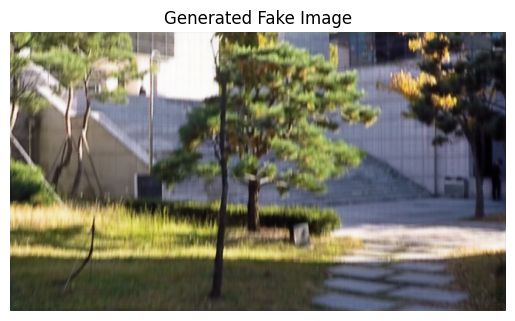

In [45]:
with torch.no_grad():
    fake_sharp = G(blur_tensor)
fake_sharp = fake_sharp.squeeze(0)
fake_show = fake_sharp * 0.5 + 0.5  # [-1,1] -> [0,1]
fake_show = fake_show.permute(1, 2, 0).cpu()  # [H,W,C]
print(fake_sharp.shape)
plt.imshow(fake_show)
plt.title("Generated Fake Image")
plt.axis('off')
plt.show()

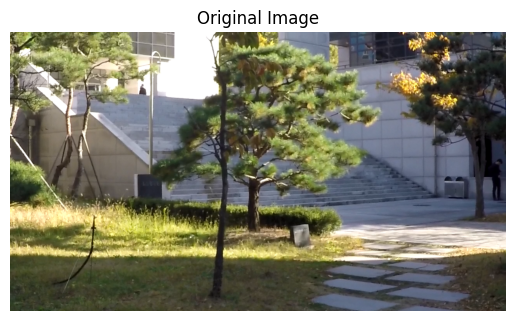

In [48]:
img_path = '/content/drive/MyDrive/Colab Notebooks/sharp.png'
sharp_img = Image.open(img_path).convert('RGB')  # ensure 3 channels

# Show original image
plt.imshow(sharp_img)
plt.title("Original Image")
plt.axis('off')
plt.show()